In [1]:
import astropy
from astropy.table import Table
from astropy.io import fits

import sys, os
from argparse import Namespace
import numpy as np

from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform

from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from io import BytesIO

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

In [2]:
import cmasher as cmr
import pandas as pd

from pathlib import Path
PATH = Path('../..').resolve()

In [33]:
%matplotlib notebook
import traceback, functools

# save error message in the global errorlist variable
def save_errors(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            errorlist.append(traceback.format_exc())
    return wrapper

class InteractivePlot:
    """Standard version selects random sample of objects from cluster"""
    def __init__(self, tcl, tsne_obj, objects, spd=None, nside=4,
                 filename=None, highlight=None, highlightpars=None):
        """
        tcl is the list of clusters
        tsne_obj is the t-SNE coordinate mapping
        objects is a table with information on the objects (names, filenames)
        
        Optional keyword parameters:
        spd is a square array [nobj,nobj] of distances
            Default is to compute distances from tsne_obj.
        nside determines number of images (nside*nside)        
        filename is the name for a saved figure (default is none)
        highlight is an index list of points to mark
            Then highlightpars can be a dict with plot properties as parameters
            to pyplot.scatter
        """
        self.tcl = tcl
        self.tsne_obj = tsne_obj
        self.objects = objects
        self.clcount = np.bincount(self.tcl)
        self.nside = nside
        self.filename = filename
        self.highlight = highlight
        self.highlightpars = dict(facecolor='none', color='k',s=7)
        if highlightpars:
            self.highlightpars.update(highlightpars)
        if spd is None:
            spd = squareform(pdist(tsne_obj))
        else:
            assert spd.shape == (len(objects),len(objects))
        self.pdist = spd
        self.create_plot()

    def create_plot(self):
        plt.rcParams.update({"font.size":8})
        self.fig = plt.figure(1,(15,7.5))
        # t-SNE plot goes in left half of display
        self.ptsne = self.fig.add_subplot(121)
        # cc = self.colormap()
        self.ptsne.scatter(self.tsne_obj[:,0],self.tsne_obj[:,1],c=self.tcl,cmap=cmr.heat_r,s=5,edgecolor='none')
        self.ptsne.set_title(self.title())
        if self.highlight is not None:
            self.ptsne.scatter(self.tsne_obj[self.highlight,0],self.tsne_obj[self.highlight,1],
                               **self.highlightpars)
        # self.ptsne.legend(loc='best')
        self.prevplt = None
        self.label = self.ptsne.set_xlabel("x")
        # nside x nside cutouts go in right half
        self.subplots = []
        nside = self.nside
        iplot = nside
        for i in range(nside*nside):
            iplot = iplot + 1
            if (iplot % (2*nside))==1:
                iplot = iplot+nside
            self.subplots.append(self.fig.add_subplot(nside,2*nside,iplot))
            self.subplots[-1].set_axis_off()
            self.subplots[-1].set_title(f"Sample {i+1}",size=9)
        self.plotobjects = [None]*len(self.subplots)
        self.fig.tight_layout()
        self.saved = False
        self.fig.canvas.mpl_connect('close_event', self.close)
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.show()

    @save_errors
    def close(self,event):
        if (not self.saved) and self.filename:
            self.saved = True
            self.fig.savefig(self.filename)
            errorlist.append(f"Saved figure to {self.filename}")

    def colormap(self):
        """Create colors for the clusters"""
        nclusters = len(self.clcount)-1
        # create color array for the clusters by wrapping the tab20 array
        cmap = cmr.heat_r
        ncolors = len(cmap.colors)
        cc = np.tile(np.array(cmap.colors),((nclusters+ncolors-1)//ncolors,1))
        cc = cc[:nclusters]
        return cc
        
    def findclosest(self,x,y):
        return np.argmin((self.tsne_obj[:,0]-x)**2+(self.tsne_obj[:,1]-y)**2)

    def title(self):
        return "Click to show random images within cluster"

    def select_sample(self,x,y):
        """Select a list of points near the click position
        
        This version shows the closest point plus a random sample of
        other members of the same cluster.
        """
        k = self.findclosest(x,y)
        i = self.tcl[k]
        nc = len(self.subplots)
        ww = np.where((self.tcl==i)&(np.arange(self.tcl.shape[0])!=k))[0]
        if len(ww) > nc-1:
            j = np.random.choice(ww,size=nc-1,replace=False)
        else:
            # group is too small
            j = ww
        j = np.insert(j,0,k)
        return j
    
    def showcluster(self,x,y):
        """Mark some objects and show images"""
        j = self.select_sample(x,y)
        self.label.set_text(f"x={x:.3f} y={y:.3f}")
        i = self.tcl[j[0]]
        if self.prevplt is not None:
            [x.remove() for x in self.prevplt]
        for sp in self.subplots:
            sp.clear()
            sp.set_axis_off()
        self.prevplt = self.ptsne.plot(self.tsne_obj[j,0],self.tsne_obj[j,1],'ks',
                                       label=f'Cl {i} ({self.clcount[i]} members)',
                                       fillstyle='none',alpha=0.3)
        self.ptsne.legend(loc='upper right')
        self.plotobjects = [None]*len(self.subplots)
        for isp, k in enumerate(j):
            im = Image.open(self.objects['filename'][k])
            sp = self.subplots[isp]
            pim = sp.imshow(im,origin='upper')
            self.plotobjects[isp] = k
            cdist = self.pdist[k,j[0]]
            sp.set_title("{}".format(self.objects['name'][k]),
                        size=7)

    @save_errors
    def onclick(self,event):
        if event.key == "alt":
            # Opt+click closes the plot
            plt.close(self.fig)
            if errorlist:
                print('\n'.join(errorlist))
        x = event.xdata
        y = event.ydata
        try:
            # allow clicks on the displayed images
            # this raises a ValueError if not in the list
            i = self.subplots.index(event.inaxes)
            j = self.plotobjects[i]
            if j is None:
                # ignore clicks on unpopulated images
                return
            x = self.tsne_obj[j,0]
            y = self.tsne_obj[j,1]
        except ValueError:
            pass
        self.showcluster(x,y)


class InteractiveClosest(InteractivePlot):
    """Select closest points from within the cluster using pdist"""
    def title(self):
        return "Click to show closest images within cluster"

    def select_sample(self,x,y):
        k = self.findclosest(x,y)
        i = self.tcl[k]
        nc = len(self.subplots)
        ww = np.where(self.tcl==i)[0]
        ww = ww[np.argsort(self.pdist[ww,k])]
        ww = ww[:nc]
        return ww


class InteractiveAllclose(InteractivePlot):
    """Select closest points from entire sample (regardless of cluster)"""
    def title(self):
        return "Click to show closest images from any cluster"

    def select_sample(self,x,y):
        k = self.findclosest(x,y)
        nc = len(self.subplots)
        ww = np.argsort(self.pdist[:,k])
        ww = ww[:nc]
        return ww


class InteractiveFarthest(InteractivePlot):
    """Select farthest points from within the cluster"""
    def title(self):
        return "Click to show farthest images within cluster"

    def select_sample(self,x,y):
        k = self.findclosest(x,y)
        i = self.tcl[k]
        nc = len(self.subplots)
        # sort cluster members from largest to smallest distance to this object
        ww = np.where((self.tcl==i)&(np.arange(self.tcl.shape[0])!=k))[0]
        ww = ww[np.argsort(-self.pdist[ww,k])]
        ww = ww[:nc-1]
        ww = np.insert(ww,0,k)
        return ww


def fakeevent(x,y):
    from argparse import Namespace
    return Namespace(xdata=x,ydata=y,key='none')

# Load data

In [10]:
df = pd.read_csv(PATH/'results/desi-sv/desi2-umap-results.csv', index_col=0)
df.head()

,UMAP_0,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,RA,DEC,p_CNN,TSNE_0,TSNE_1
OBJID,,,,,,,,,,,
902918190000002396,-0.341620,0.856228,6.840964,7.069143,1.930922,5.433155,66.223965,-6.656335,0.095056,-7.851267,29.665127
902918190000003670,-2.216017,1.363551,9.400448,3.951114,4.918688,8.511930,66.277320,-6.678317,0.037117,39.536644,19.909616
902918190000003699,-2.667209,1.348225,8.992169,4.070541,6.140815,7.254971,66.278287,-6.657616,0.030341,36.445484,8.705595
902918190000004561,-2.129466,1.385508,9.324391,4.647331,4.263889,7.596617,66.317535,-6.652278,0.047317,34.181145,22.927256
902918190000004863,-0.563477,1.054309,7.873556,6.766508,1.769965,5.962242,66.331727,-6.681737,0.092496,-6.796018,35.779130


In [14]:
dfx = df.sample(10000)

In [15]:
objIDs = dfx.index.values.astype(str)

objects = Table(
    data={
        'name': objIDs,
        'filename': [f'{PATH}/images-legacy_desi-sv/{objID}.jpg' for objID in objIDs],
    }
)

In [16]:
# clustering for colors
clusters = pd.cut(dfx.p_CNN.apply(np.log10), 50, labels=False)

<IPython.core.display.Javascript object>


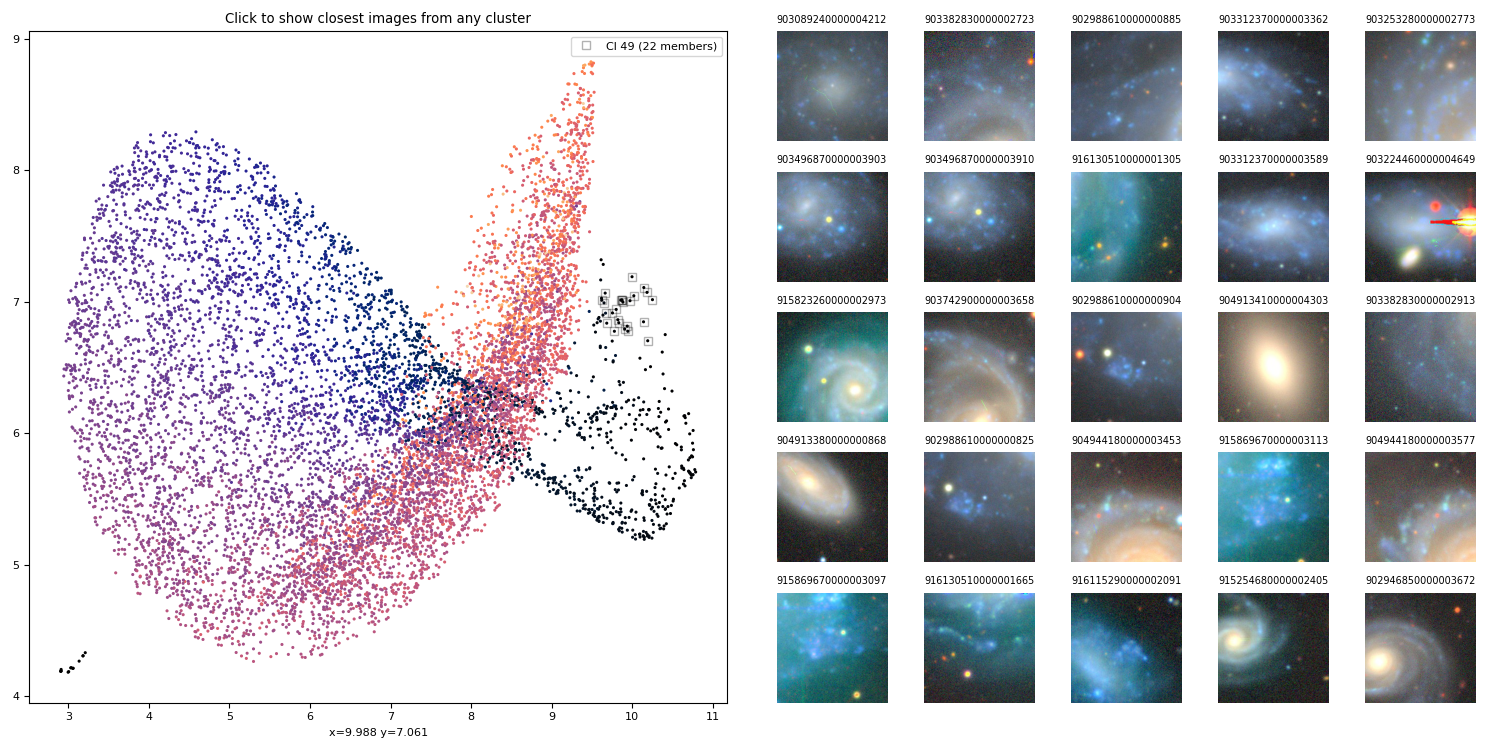

In [34]:
errorlist = []
p = InteractiveAllclose(clusters.values, dfx[['UMAP_2', 'UMAP_5']].values, objects, nside=5) #,nside=4,spd=spd,filename='tsne-hisp-demo.png')

In [22]:
print('\n'.join(errorlist))